# Introduction

This library implements a multi-objective (2, 3 and 4 objectives are supported) non-dominated archive. It provides easy and fast access to the hypervolume and [hypervolume plus](https://doi.org/10.1109/TEVC.2022.3210897) indicators, the contributing hypervolume of each element, and to the [uncrowded hypervolume improvement](https://arxiv.org/abs/1904.08823) of any given point in objective space.

Additionally, it provides a constrained version of the archive, which allows to store points with constraints and to compute the [ICMOP](https://doi.org/10.1016/j.ins.2022.05.106) indicator. 

## Installation

Either via
```
pip install git+https://github.com/CMA-ES/moarchiving.git@master
```

or simply via

```
pip install moarchiving
```


## Testing

```
python -m moarchiving.test
```

on a system shell should output something like

```
doctest.testmod(<module 'moarchiving.moarchiving2d' from '...\\moarchiving\\moarchiving2d.py'>)
TestResults(failed=0, attempted=90)

...

OK
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromModule(<module 'moarchiving.tests.test_sorted_list' from '...\\moarchiving\\tests\\test_sorted_list.py'>))
.......
----------------------------------------------------------------------
Ran 7 tests in 0.001s
```


## Details

`moarchiving` uses the [`fractions.Fraction`](https://docs.python.org/3/library/fractions.html) type to avoid rounding errors when computing hypervolume differences, but its usage can also easily switched off by assigning the respective class attributes `hypervolume_computation_float_type` and `hypervolume_final_float_type`.

## Links

- [Code on Github](https://github.com/CMA-ES/moarchiving)
- Documentation (possibly slighly outdated) in
  - [this page plus performance test examples](https://cma-es.github.io/moarchiving/)
  - [apidocs format](https://cma-es.github.io/moarchiving/moarchiving-apidocs/index.html)
  - [epydocs format](https://cma-es.github.io/moarchiving/moarchiving-epydocs/index.html)

## Releases
- 0.8.0 addition of MOArchive classes for 3 and 4 dimensions, as well as a class for handling constrained problems
- 0.7.0 reimplementation of `BiobjectiveNondominatedSortedList.hypervolume_improvement` by extracting a sublist first.
- 0.6.0 the `infos` attribute is a `list` with corresponding (arbitrary) information, e.g. for keeping the respective solutions.
- 0.5.3 fixed assertion error when not using `fractions.Fraction`
- 0.5.2 first published version

# Usage examples
1. [Initialization](#1-initialization)
2. [Constrained archive](#2-constrained-moarchive)
3. [Infos](#3-accessing-infos-of-the-archive)
4. [Adding points](#4-adding-points)
5. [Archive size](#5-size-of-the-archive)
6. [Performance indicators](#6-performance-indicators)
7. [Contributing hypervolume](#7-contributing-hypervolumes)
8. [Hypervolume improvement](#8-hypervolume-improvement)
9. [Distance to pareto front](#9-distance-to-pareto-front)
10. [Fractions](#10-turning-fractions-on-and-off)
11. [Additional functions](#11-additional-functionalities)
12. [Indicator visualizations](#12-visualization-of-indicators)
13. [Performance tests](#13-performance-tests)

### 1. Initialization
MOArchive object can be created using `get_archive` function providing a list of objective values, reference point or at least the number of objectives. Note that additional points can always be added using `add` or `add_list` functions, but reference point can not be changed once the object is initialized. A list of information strings can be provided for each point, which will be stored as long as the corresponding point stays in the archive (e.g. the x values used to generate the objective values). At any point the list of non-dominated points and their corresponding infos can be accessed. 

In [1]:
from moarchiving.get_archive import get_mo_archive

moa2d = get_mo_archive([[1, 5], [2, 3], [4, 5], [5, 0]], reference_point=[10, 10], infos=["a", "b", "c", "d"])
moa3d = get_mo_archive([[1, 2, 3], [3, 2, 1], [3, 3, 0], [2, 2, 1]], [10, 10, 10], ["a", "b", "c", "d"])
moa4d = get_mo_archive([[1, 2, 3, 4], [1, 3, 4, 5], [4, 3, 2, 1], [1, 3, 0, 1]], reference_point=[10, 10, 10, 10], infos=["a", "b", "c", "d"])

print("points in the 2d archive:", list(moa2d))
print("points in the 3d archive:", list(moa3d))
print("points in the 4d archive:", list(moa4d))

points in the 2d archive: [[1, 5], [2, 3], [5, 0]]
points in the 3d archive: [[3, 3, 0], [2, 2, 1], [1, 2, 3]]
points in the 4d archive: [[1, 3, 0, 1], [1, 2, 3, 4]]


MOArchive objects can also be initialized empty.

In [2]:
moa = get_mo_archive(reference_point=[4, 4, 4])
print("points in the empty archive:", list(moa))

points in the empty archive: []


### 2. Constrained MOArchive
Constrained MOArchive supports all the functionalities of a non-constrained MOArchive, with the additional handling of constraints when adding or initializing the archive (next to the objectives of a point we need to add the constraints in form of a list or a number). 

In [3]:
from moarchiving.get_archive import get_cmo_archive

cmoa = get_cmo_archive([[1, 2, 3], [1, 3, 4], [4, 3, 2], [1, 3, 0]], [[3, 0], [0, 0], [0, 0], [0, 1]], 
                       reference_point=[5, 5, 5], infos=["a", "b", "c", "d"])
print("points in the archive:", list(cmoa))

points in the archive: [[4, 3, 2], [1, 3, 4]]


### 3. Accessing infos of the archive
`archive.infos` is used to get the infos of the archive

In [4]:
# infos of the previously defined empty archive
print("infos of the empty archive", moa.infos)
print("infos of the constrained archive", cmoa.infos)

infos of the empty archive []
infos of the constrained archive ['c', 'b']


### 4. Adding points
Points can be added to MOArchive at any time, using `add` (for one point) and `add_list` (for multiple points) functions.

In [5]:
moa.add([1, 2, 3], "a")
print("points:", list(moa))
print("infos:", moa.infos)

moa.add_list([[3, 2, 1], [2, 3, 2], [2, 2, 2]], ["b", "c", "d"])
print("points:", list(moa))
print("infos:", moa.infos)

points: [[1, 2, 3]]
infos: ['a']
points: [[3, 2, 1], [2, 2, 2], [1, 2, 3]]
infos: ['b', 'd', 'a']


When adding to constrained archive, constraint violations must be added as well

In [6]:
cmoa.add_list([[3, 3, 3], [1, 1, 1]], [[0, 0], [42, 0]], ["e", "f"])
print("points:", list(cmoa))
print("infos:", cmoa.infos)

points: [[4, 3, 2], [3, 3, 3], [1, 3, 4]]
infos: ['c', 'e', 'b']


### 5. Size of the archive
The MOArchive implements some functionality of a list (In 2D case it actually extends the list class, but this is not the case in 3 and 4D), in particular the `len` method to get the number of points in the archive as well as the `in` keyword to check if a point is in the archive.

In [7]:
print("Points in the archive:", list(moa))
print("Length of the archive:", len(moa))
print("[2, 2, 2] in moa:", [2, 2, 2] in moa)
print("[3, 2, 0] in moa:", [3, 2, 0] in moa)

Points in the archive: [[3, 2, 1], [2, 2, 2], [1, 2, 3]]
Length of the archive: 3
[2, 2, 2] in moa: True
[3, 2, 0] in moa: False


### 6. Performance indicators
In order that all the performance indicators are easily comparable, we define all of them as a maximization indicators (by multiplying hypervolume plus and ICMOP indicators with -1). In that case when the archive is not empty, all the indicators are positive and have the same value. 

Accessing the hypervolume of the archive is done using the `hypervolume` attribute or the `hypervolume_plus` attribute for the hypervolume plus indicator. 

In [8]:
print("Hypervolume of the archive:", moa.hypervolume)
print("Hypervolume plus of the archive:", moa.hypervolume_plus)

Hypervolume of the archive: 12
Hypervolume plus of the archive: 12


In case of a constrained MOArchive the `icmop` attribute can be accessed as well. 

In [9]:
print("Hyperolume of the constrained archive:", cmoa.hypervolume)
print("Hypervolume plus of the constrained archive:", cmoa.hypervolume_plus)
print("ICMOP of the constrained archive:", cmoa.icmop)

Hyperolume of the constrained archive: 14
Hypervolume plus of the constrained archive: 14
ICMOP of the constrained archive: 14


### 7. Contributing hypervolumes
Returns a list of contributions for each point of the archive. Alternatively can also be computed for a single point using `contributing_hypervolume(point)` method.

In [10]:
for i, objectives in enumerate(moa):
    assert moa.contributing_hypervolume(objectives) == moa.contributing_hypervolumes[i]
    print("contributing hv of point", objectives, "is", moa.contributing_hypervolume(objectives))

print("All contributing hypervolumes:", moa.contributing_hypervolumes)

contributing hv of point [3, 2, 1] is 2
contributing hv of point [2, 2, 2] is 2
contributing hv of point [1, 2, 3] is 2
All contributing hypervolumes: [Fraction(2, 1), Fraction(2, 1), Fraction(2, 1)]


### 8. Hypervolume improvement
Returns the improvement of the hypervolume if we would add the point to the archive.

In [11]:
point = [1, 3, 0]
print(f"hypervolume before adding {point}: {moa.hypervolume}")
print(f"hypervolume improvement of point {point}: {moa.hypervolume_improvement(point)}")
moa.add(point)
print(f"hypervolume after adding {point}: {moa.hypervolume}")

hypervolume before adding [1, 3, 0]: 12
hypervolume improvement of point [1, 3, 0]: 6
hypervolume after adding [1, 3, 0]: 18


### 9. Distance to pareto front
Returns the distance between a dominated point and the pareto front.

In [12]:
print(f"Current archive: {list(moa)}")
print("Distance of [3, 2, 1] to pareto front:", moa.distance_to_pareto_front([3, 2, 1]))
print("Distance of [3, 2, 2] to pareto front:", moa.distance_to_pareto_front([3, 3, 3]))

Current archive: [[1, 3, 0], [3, 2, 1], [2, 2, 2], [1, 2, 3]]
Distance of [3, 2, 1] to pareto front: 0.0
Distance of [3, 2, 2] to pareto front: 1.0


### 10. Turning fractions on and off
To avoid the loss of precision, fractions are used by default. Changing this to float can be done by setting function attributes `hypervolume_final_float_type` and `hypervolume_computation_float_type`.

In [13]:
import fractions
get_mo_archive.hypervolume_computation_float_type = fractions.Fraction
get_mo_archive.hypervolume_final_float_type = fractions.Fraction

moa3_fr = get_mo_archive([[1, 2, 3], [2, 1, 3], [3, 3, 1.32], [1.3, 1.3, 3], [1.7, 1.1, 2]], reference_point=[4, 4, 4])
print(moa3_fr.hypervolume)

get_mo_archive.hypervolume_computation_float_type = float
get_mo_archive.hypervolume_final_float_type = float

moa3_nofr = get_mo_archive([[1, 2, 3], [2, 1, 3], [3, 3, 1.32], [1.3, 1.3, 3], [1.7, 1.1, 2]], reference_point=[4, 4, 4])
print(moa3_nofr.hypervolume)

161245156349030777798724819133399/10141204801825835211973625643008
15.899999999999999


### 11. Additional functionalities:
MOArchive also implements additional functions to check for the given point not in the archive:
- `in_domain`: point is in domain?
- `dominates`: point is dominated by the archive?
- `dominators`: which/how many points dominate the given point?

In [14]:
points_list = [[5, 5, 0], [2, 2, 3], [0, 2, 3]]
print("archive:", list(moa), "\n")
print("point     | in domain | dominates | num of dominators | dominators")
print("----------|-----------|-----------|-------------------|-----------")
for point in points_list:
    print(f"{point} | {moa.in_domain(point):9} | {moa.dominates(point):9} | "
          f"{moa.dominators(point, number_only=True):17} | {moa.dominators(point)}")

archive: [[1, 3, 0], [3, 2, 1], [2, 2, 2], [1, 2, 3]] 

point     | in domain | dominates | num of dominators | dominators
----------|-----------|-----------|-------------------|-----------
[5, 5, 0] |         0 |         1 |                 1 | [[1, 3, 0]]
[2, 2, 3] |         1 |         1 |                 2 | [[2, 2, 2], [1, 2, 3]]
[0, 2, 3] |         1 |         0 |                 0 | []


### 12. Visualization of indicators
By saving the values of indicators for each point added to the archive, we can visualize the behavior of the archive over time.

In [15]:
import matplotlib.pyplot as plt
import random

n_obj = 3

indicators_cmoa = []
indicators_moa = []
cmoa = get_cmo_archive(reference_point=[0.5] * n_obj, n_obj=n_obj, tau=0.2)
moa = get_mo_archive(reference_point=[0.1] * n_obj, n_obj=n_obj)

for i in range(2000):
    objectives = [random.random() for _ in range(n_obj)]
    constraints = [max(random.random() - 0.1, 0), max(random.random() - 0.1, 0)]
    
    cmoa.add(objectives, constraints, info=f"point_{i}")
    moa.add(objectives, info=f"point_{i}")
    
    indicators_cmoa.append((cmoa.icmop, cmoa.hypervolume_plus, cmoa.hypervolume))
    indicators_moa.append((moa.hypervolume_plus, moa.hypervolume))
    

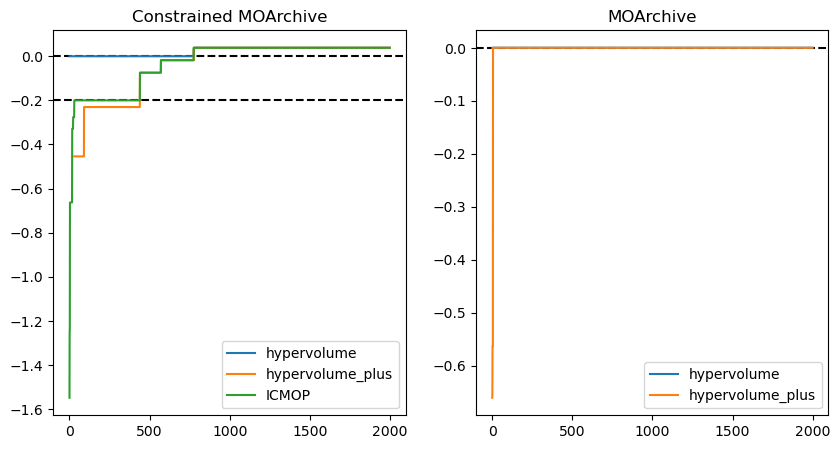

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot([x[2] for x in indicators_cmoa], label="hypervolume")
axs[0].plot([x[1] for x in indicators_cmoa], label="hypervolume_plus")
axs[0].plot([x[0] for x in indicators_cmoa], label="ICMOP")
axs[0].axhline(0, color="black", linestyle="--", zorder=0)
axs[0].axhline(-cmoa.tau, color="black", linestyle="--", zorder=0)
axs[0].set_title("Constrained MOArchive")
axs[0].legend()

axs[1].plot([x[1] for x in indicators_moa], label="hypervolume")
axs[1].plot([x[0] for x in indicators_moa], label="hypervolume_plus")
axs[1].set_title("MOArchive")
axs[1].axhline(0, color="black", linestyle="--", zorder=0)
axs[1].legend()
plt.show()

### 13. performance tests

In [22]:
import time
from moarchiving.tests.point_sampling import get_non_dominated_points
import matplotlib.pyplot as plt
test_archive_sizes = [0] + [2 ** i for i in range(21)]

get_mo_archive.hypervolume_computation_float_type = fractions.Fraction
get_mo_archive.hypervolume_final_float_type = fractions.Fraction

#### 13.1. Initializing archive

Testing 2 objectives
...............
Testing 3 objectives
............
Testing 4 objectives
.........


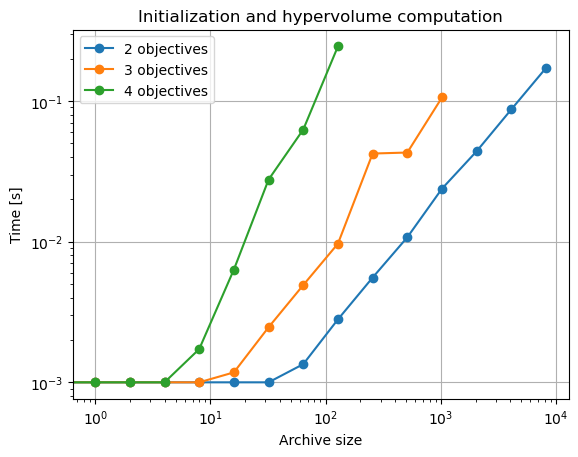

In [23]:
n_repeats = 100
time_limit = 10

for n_obj in [2, 3, 4]:
    print(f"Testing {n_obj} objectives")
    times = []
    archive_sizes = []
    
    for archive_size in test_archive_sizes:
        points = get_non_dominated_points(archive_size, n_dim=n_obj)
        t0 = time.time()
        moa = [get_mo_archive(points, [1] * n_obj, n_obj=n_obj)
               for _ in range(n_repeats)]
        hv = [m.hypervolume for m in moa]
        t1 = time.time()
        
        times.append(max((t1 - t0) / n_repeats, 10e-4))
        print(".", end="")
        archive_sizes.append(archive_size)
        
        if t1 - t0 > time_limit:
            break
    print()
    
    plt.plot(archive_sizes, times, '-o', label=f"{n_obj} objectives")

plt.title("Initialization and hypervolume computation")
plt.xlabel("Archive size")
plt.ylabel("Time [s]")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.show()

#### 13.2. Adding a point to existing archive

Testing 2 objectives
......................
Testing 3 objectives
.................
Testing 4 objectives
...........


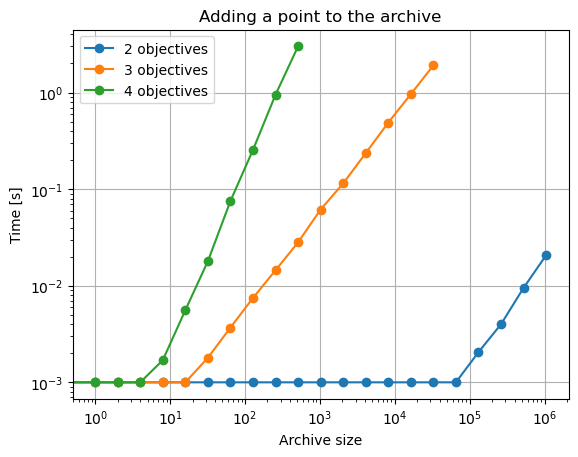

In [24]:
n_repeats = 10
time_limit = 10

for n_obj in [2, 3, 4]:
    print(f"Testing {n_obj} objectives")
    times = []
    archive_sizes = []

    for archive_size in test_archive_sizes:
        
        points = get_non_dominated_points(archive_size, n_dim=n_obj)
        add_points = get_non_dominated_points(n_repeats, n_dim=n_obj)
        moa = [get_mo_archive(points, [1] * n_obj, n_obj=n_obj) for _ in range(n_repeats)]
        
        t0 = time.time()
        for i, m in enumerate(moa):
            m.add(add_points[i])
        t1 = time.time()

        times.append(max((t1 - t0) / n_repeats, 10e-4))
        print(".", end="")
        archive_sizes.append(archive_size)

        if t1 - t0 > time_limit:
            break
    print()
    time.sleep(1)

    plt.plot(archive_sizes, times, '-o', label=f"{n_obj} objectives")

plt.title("Adding a point to the archive")
plt.xlabel("Archive size")
plt.ylabel("Time [s]")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.show()